In [3]:
import os
import torch
import pandas as pd
from models.part_cem import PartCEM
import matplotlib.pyplot as plt
from datasets import build_datasets
from torchvision.utils import make_grid

In [9]:
b,k,c,h,w = 16, 8, 128, 14, 14
a, b = torch.randn(b,k,h,w), torch.randn(b,c,h,w)

In [28]:
torch.equal(torch.einsum('bkhw,bchw->bkchw', a, b).mean((-1,-2)), (a.unsqueeze(1) * b.unsqueeze(2)).mean((-1,-2)).permute(0,2,1))

True

tensor([[[-4.9230e-02, -9.8833e-02,  4.0327e-02,  ...,  1.3061e-01,
           9.9715e-02, -5.6417e-03],
         [ 7.0569e-02,  3.2073e-02,  5.3760e-03,  ..., -1.8747e-02,
           5.9648e-02,  3.4715e-02],
         [ 8.5057e-03,  4.2148e-02, -2.6301e-02,  ..., -4.5465e-02,
           5.5654e-02, -3.0145e-02],
         ...,
         [ 2.3527e-02,  1.8772e-01,  1.1527e-01,  ...,  1.0654e-01,
           3.3976e-02, -1.4034e-02],
         [ 3.2456e-03,  1.7626e-02, -3.9505e-02,  ...,  5.9612e-03,
           1.1152e-01,  4.1947e-02],
         [-1.4656e-02, -8.1049e-02, -4.5232e-02,  ..., -2.1627e-04,
           1.2239e-02, -5.6032e-03]],

        [[-5.0160e-02,  1.0788e-01, -9.3159e-02,  ..., -8.8391e-02,
          -3.8991e-03,  6.5073e-02],
         [ 8.2188e-02,  7.8016e-03,  1.1944e-01,  ...,  1.4117e-02,
           9.6135e-02, -1.3401e-01],
         [ 9.3442e-02, -1.1184e-02, -6.8431e-02,  ...,  3.1176e-02,
           1.4152e-02,  4.8408e-02],
         ...,
         [ 1.3211e-01, -1

In [10]:
model = PartCEM()
state_dict = torch.load('CUB_runs/2024-03-24_22-58/checkpoint.pt')
model.load_state_dict(state_dict=state_dict)

<All keys matched successfully>

In [11]:
(dataset_train, dataset_val, dataset_test), attr_indices, class_attrs_df = build_datasets(
    dataset_dir='datasets/CUB',
    attr_subset='cbm',
    use_class_level_attr=True,
    image_size=448
)

attr_name_df = pd.read_csv('datasets/CUB/attributes.txt', sep=' ',
                           names=['attr_id', 'attr_name']).drop(columns=['attr_id'])
attributes_dict = torch.load('CUB_runs/2024-03-24_22-58/attributes.pkl')
use_attr_idxs = attributes_dict['use_attribute_indices']

Ground Truth: 0


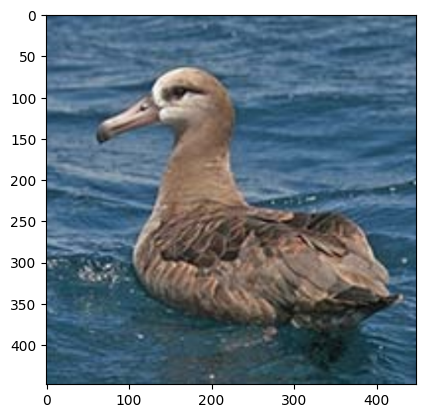

In [38]:
img_id, image, class_id, attrs_gt = dataset_test[11]
print('Ground Truth:', class_id.item())
plt.imshow(image.permute(1,2,0).numpy())
plt.show()

Prediction: 1
0 has_bill_shape::hooked_seabird
1 has_breast_pattern::solid
2 has_eye_color::black
3 has_bill_length::about_the_same_as_head
4 has_size::medium_(9_-_16_in)
5 has_back_pattern::solid
6 has_tail_pattern::solid
7 has_belly_pattern::solid


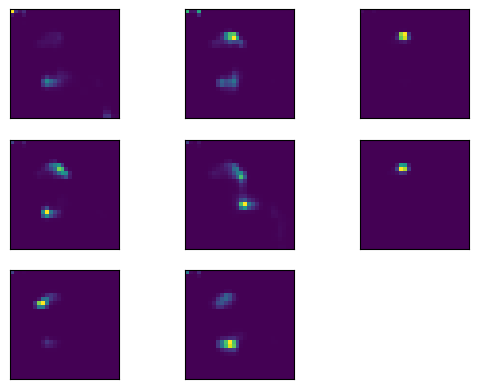

In [60]:
import numpy as np
import torchvision.transforms.functional as F

attr_mask = attrs_gt.bool().numpy()
score_maps, concept_scores, preds, _ = model(image.unsqueeze(0))
relevant_score_maps = score_maps.squeeze(0)[:-1, ...][attr_mask, ...]

print('Prediction:', torch.argmax(torch.softmax(preds.squeeze(0), dim=-1)).item())
attr_names = attr_name_df.iloc[use_attr_idxs].iloc[attr_mask]['attr_name'].to_list()
for i, n in enumerate(attr_names):
    print(i, n)

fig, axs = plt.subplots(nrows=3, ncols=3, squeeze=False)
for i, ax in enumerate(axs.flatten()):
    if i >= relevant_score_maps.size(0):
        ax.set_visible(False)
        continue
    ax.imshow(relevant_score_maps[i, :, :].detach().numpy())
    ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])